[1차시 실습 - 이미지 분류]
CNN 모델(LeNet)을 CIFAR10 데이터셋으로 학습시켜 성능 60% 이상으로 개선하기
* 만약 성공한 경우 사전학습된 ResNet 모델을 사용하여 transfer learning 구현해보기(필수 X)

In [ ]:
# 1. torchvision 패키지를 이용하여 CIFAR10 학습 데이터셋과 테스트 데이터셋을 내려받은 후 전처리

# 2. Convolutional neural network(LeNet) 정의하기

# 3. Loss 함수 정의하기

# 4. 학습 데이터셋으로 2번에서 만든 CNN 학습하기

# 5. 학습이 끝난 후 테스트 데이터셋으로 최종 성능 평가하기

 1. torchvision 패키지를 이용하여 CIFAR10 학습 데이터셋과 테스트 데이터셋을 내려받은 후 전처리

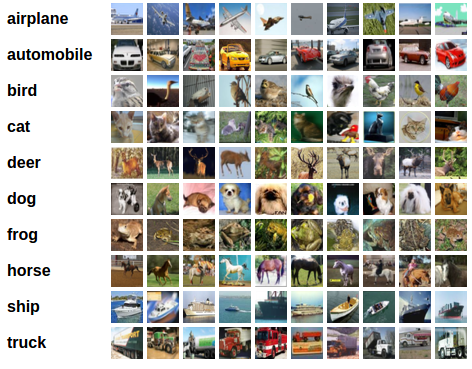

CIFAR10 이미지는 RGB 3채널의 32*32 크기의 이미지들로 ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’의 10가지 클래스가 섞여있다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), # ToTensor()는 PIL image 또는 Numpy.ndarray일 경우 텐서로 변환해주는기능
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 텐서의 이미지를 각 평균 0.5, 표준편차 0.5로 정규화

왜 normalize를 해주는가? 
1. 학습 속도가 빠르다.
2. 정규화하지 않은 Cost function과 정규화한 Cost function이 있을때, 정규화한 경우가 Local optimum에서 더 빨리 빠져나올수 있다.

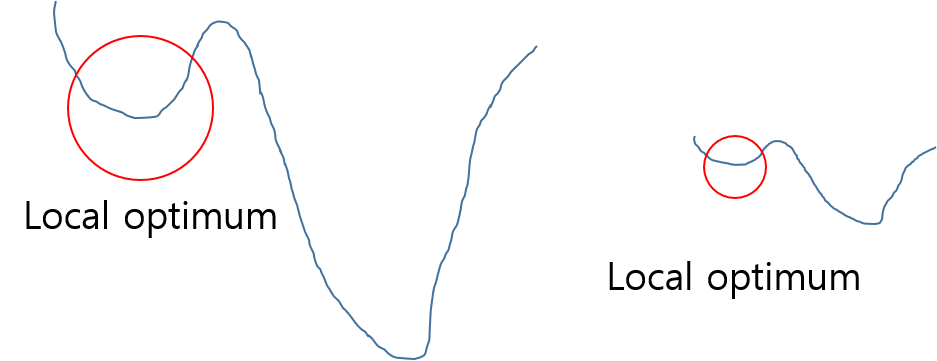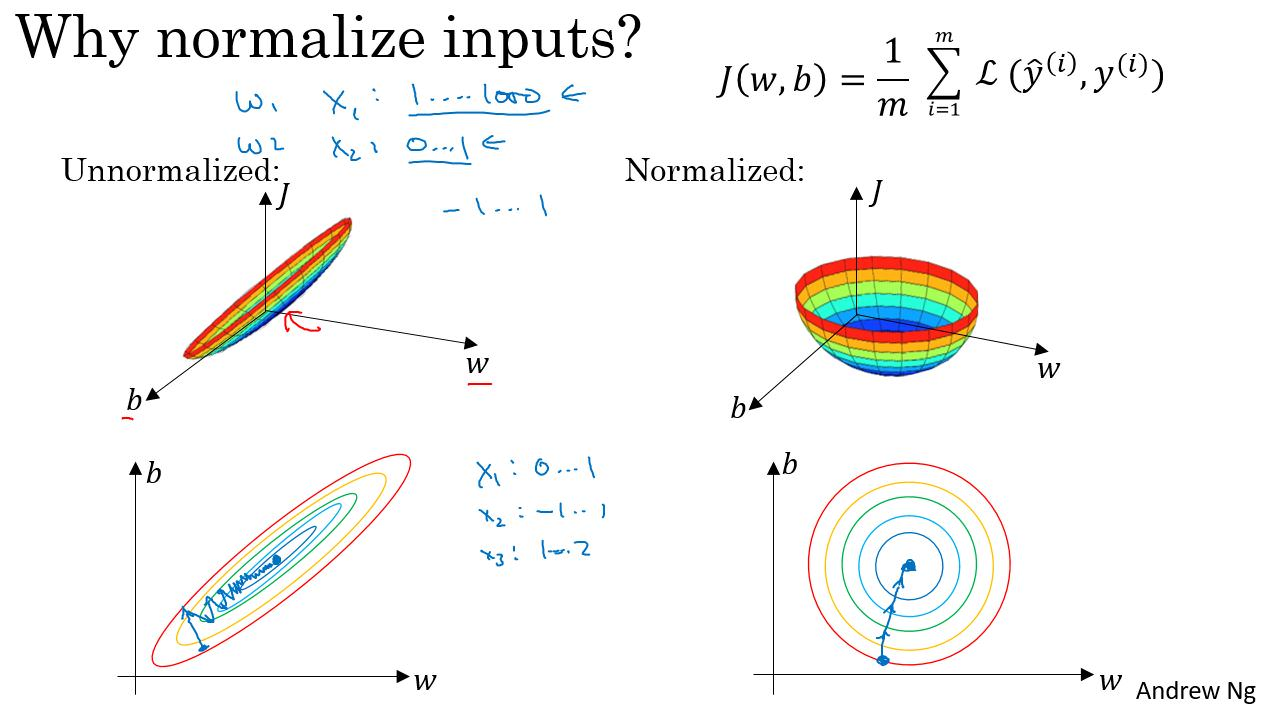

In [ ]:
Trainset = torchvision.datasets.CIFAR10(root='./drive/MyDrive/data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
# DataLoader클래스는 데이터셋을 샘플러와 병합하여 iterable한 형태로 출력해준다.
# 즉, 데이터셋을 for문으로 돌릴수 있게 해준다.
trainloader = torch.utils.data.DataLoader(Trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [ ]:
Testset = torchvision.datasets.CIFAR10(root='./drive/MyDrive/testdata' , train=False, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
testloader = torch.utils.data.DataLoader(Testset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

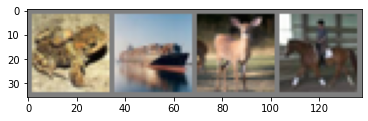

 frog  ship  deer horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#이미지 확인하기

def imshow(img):
    img = img / 2 + 0.5     # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지 뽑기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 이미지별 라벨 (클래스) 보여주기
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Convolutional neural network(LeNet) 정의하기

Conv(C1) - Subsampling(S2) - Conv(C3) - Subsampling(S4) - FC - FC

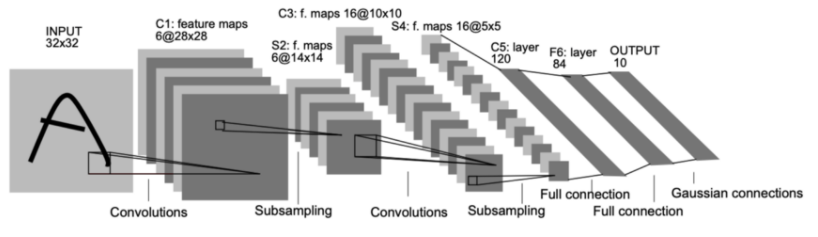

In [ ]:
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        # self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # x = F.avg_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # x = F.avg_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1,16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = F.softmax(self.fc3(x),dim=1)
        return x
      

lenet = LeNet()
summary(lenet,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


3. Loss 함수와 Optimizer 정의하기

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(lenet.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001) 

4. 학습 데이터셋으로 2번에서 만든 CNN 학습하기

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = lenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.869
[1,  4000] loss: 1.602
[1,  6000] loss: 1.516
[1,  8000] loss: 1.454
[1, 10000] loss: 1.407
[1, 12000] loss: 1.366
[2,  2000] loss: 1.303
[2,  4000] loss: 1.289
[2,  6000] loss: 1.266
[2,  8000] loss: 1.261
[2, 10000] loss: 1.261
[2, 12000] loss: 1.245
Finished Training


5. 학습이 끝난 후 테스트 데이터셋으로 최종 성능 평가하기

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = lenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [ ]:
# MaxPooling + CrossEntropyLoss + SGD => 56%
# MaxPooling + CrossEntropyLoss + Adam => 59%
# AvgPooling + CrossEntropyLoss + Adam => 53%
# MaxPooling + CrossEntropyLoss + Adam + model마지막단 softmax로 교체 => 37%